In [299]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline


## Implementation of the stability criterion from Laskar 2017, http://adsabs.harvard.edu/abs/2017A&amp;A...605A..72L


$\beta$ for planet $i$ is defined as,

$\beta_i = 2 \frac{C}{\Lambda_i C_c} $ 

where, 

$ \frac{C}{\Lambda_i} = \sum_{k=1}^n \frac{m_k}{m_i} \left(\frac{P_k}{P_i} \right)^{1/3} \left[1 - \sqrt{1 - e_k^2}\right]$

and $C_c$ is found by the following procedure: 

1) If the planet is the innermost planet then $C_c = 1$

1) If the planet is not the innermost planet, then given $\alpha = (P_{i}/P_{i-1})^{2/3}$ and $\gamma = m_{i}/m_{i-1}$ find the value for $e_c$ such that,

$ F(e_c,\alpha,\gamma) = \alpha e + \frac{\gamma e}{\sqrt{\alpha (1 -e^2) + (\gamma e)^2}} -1 + \alpha = 0$

2) Given $e_c$, $e_c'$ is found via $e_c' = 1 - \alpha - \alpha e_c$

3) Given $e_c$ and $e_c'$ compute the AMD for planet pair with $e_{i-1}=e_c$ and $e_{i} = e_c'$,

$C_c = \gamma \sqrt{\alpha} (1 - \sqrt{1 - e_c^2}) + (1 - \sqrt{1 - e_c'^2}) $

In [369]:
class System():
    def __init__(self,planets,name='',uncertainties=None):
        self.planets = planets
        self.nplanets = len(planets)
        self.name = name
        
    def amd(self,i):
        """C/Lam_i for planet i"""

        res = 0
        pi = self.planets[i]['p']
        mi = self.planets[i]['m']
        ei = self.planets[i]['e']
        for planet in self.planets:
            period = planet['p']
            mass = planet['m']
            e = planet['e']
            alpha = (period/pi)**(2./3)
            gamma = mass/mi
            res += gamma * np.sqrt(alpha) *(1 - np.sqrt(1 - e*e))
        return res
    
    def beta_values(self):
        """Get the beta values for the system"""

        res = [self.get_beta(i) for i in range(self.nplanets)]
        return np.array(res)
    def get_beta(self,i):
        """Get the beta value for the pair i-1 and i"""
        eta = self.amd(i)
        Cc = self.critical_C(i)
        return 2*eta/Cc
    def critical_C(self,i):
        """Get C_crit for the pair i-1 and i"""
        if i == 0:
            # Inner planet returns C_crit = 1
            return 1.
        planet_1 = self.planets[i-1]
        planet_2 = self.planets[i]
        p1,e1,m1 = [planet_1[i] for i in ['p','e','m']]
        p2,e2,m2 = [planet_2[i] for i in ['p','e','m']]
        alpha = (p1/p2)**(2./3)
        gamma = (m1/m2)   
        ec_in = self.get_ec(alpha,gamma)
        ec_out = 1 - alpha - alpha*ec_in
        return gamma*np.sqrt(alpha)*(1 - np.sqrt(1-ec_in*ec_in)) + (1-np.sqrt(1-ec_out*ec_out))
        
    def func(self,e,a,g):
        if e >= 1:
            return 2*a
        if e <=0:
            return -1+a
        return a*e + g*e/np.sqrt(a*(1-e*e) + (g*e)**2) - 1 + a
    def func_jac(self,e,a,g):
        return a + g*a*(a*(1-e*e) + (g*e)**3)**(-1.5) 
    def get_ec(self,a,g):
        """Find the critical eccentricty. Adjust guess if not getting a good fit.
        Guess is really ln(1-e). """
        from scipy.optimize import fsolve
        e0 = np.linspace(0,1,100)
        guess = e0[:-1][np.diff(np.sign(np.array([sys.func(i,alpha,gamma) for i in e0])))==2][0]
        guess = np.log(1-guess)
        sol = fsolve(lambda x: self.func(1-np.exp(x),a,g),guess,fprime=lambda x: self.func_jac(1-np.exp(x),a,g))
        return 1-np.exp(sol[0])
            
    def plot_system(self,zeropoint=1,fig=None,ax=None,clrbar=False):
        def _clrbar(ax,norm,cmap):
            import matplotlib
            import matplotlib.cm
            import matplotlib.colors as colors
            from mpl_toolkits.axes_grid1 import make_axes_locatable
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('top',size='3%',pad=.05)
            cmap = matplotlib.cm.get_cmap(cmap)
            cb = matplotlib.colorbar.ColorbarBase(ax=cax,cmap=cmap,norm=norm,orientation='horizontal')
            cb.ax.xaxis.set_ticks_position('top')
            cb.ax.xaxis.set_label_position('top')

        import matplotlib.colors as colors
        norm = colors.LogNorm(vmin=1e-2,vmax=1e2)
        if ax is None:
            fig,ax=plt.subplots(figsize=(8,3))
            ax.set_ylim(0,2)
            ax.set_xscale('log')
            ax.set_xlim(1e-3,1e5)
            ax.set_xlabel('Period [days]')
            ax.minorticks_on()
            ax.set_yticklabels('')
        
        if clrbar:
            _clrbar(ax,norm,'coolwarm')
        ax.axhline(zeropoint,c='k',ls=':',zorder=0)
        print('For ', self.name, ':')
        for i,planet in enumerate(self.planets):
            beta = self.get_beta(i)
            mass = planet['m']
            period = planet['p']
            size = 100*np.log10(mass * 1e-3/(3e-6) / (.1))
            print('planet',i,'beta',beta)
            ax.scatter(period,zeropoint,s=size,c=beta,cmap='coolwarm',norm=norm)
        
        
        return fig,ax

        
   

def plot_systems(system_list):
    try:
        n = len(system_list)
    except:
        n = 1
        system_list = [system_list]
    fig,ax=plt.subplots(figsize=(8,3*n))
    yticks = [10*(i+1) for i in range(n)]
    for i,sys in enumerate(system_list):
        ax.axhline(yticks[i],ls=':',c='k',zorder=0)
        sys.plot_system(fig=fig,ax=ax,zeropoint=yticks[i],clrbar=i==0)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['{}'.format(sys.name) for sys in system_list])
    
    ax.set_ylim(0,10*(n+1))
    ax.set_xscale('log')
    ax.set_xlim(1e-2,1e5)
    ax.set_xlabel('Period [days]')
    ax.minorticks_on()
    fig.tight_layout()



       

For  HD13808 :
planet 0 beta 0.36491700193827936
planet 1 beta 1.4967279914424931
For  55 Cnc :
planet 0 beta 2.3231560132994384
planet 1 beta 0.08478864716776477
planet 2 beta 0.6632681338642815
planet 3 beta 0.2594586650432933
planet 4 beta 0.0027497396327478907
For  HD 40307 :
planet 0 beta 0.6813863470463885
planet 1 beta 6.214557240023851
planet 2 beta 3.6777301089352235
planet 3 beta 10.296206865034147
planet 4 beta 19.473760416513485
planet 5 beta 0.8405508753449978


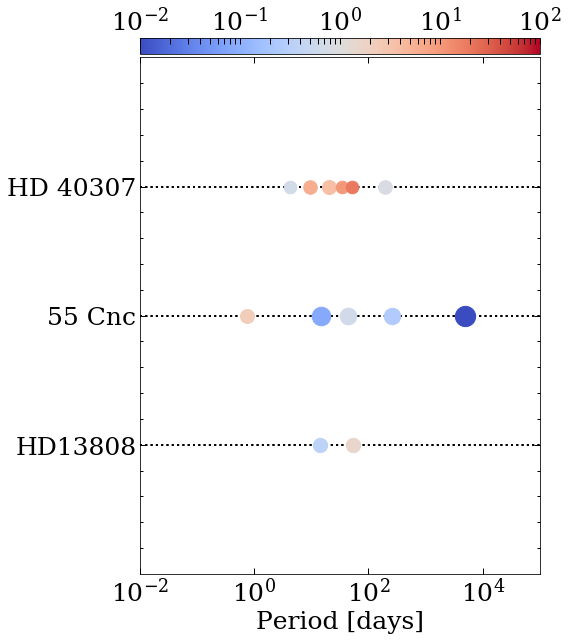

In [370]:
hd13808 = [{'p':14.182, 'e':.17, 'm':.0325},{'p':53.832,'e':.43,'m':.036}]

cnc55 = [{'p':0.7365478, 'e':.028, 'm':.02703},
        {'p':14.65314,'e':.0023,'m':.84},
        {'p':44.373,'e':.072,'m':.1784},
         {'p':260.91,'e':.08,'m':.1479},
        {'p':4867.0,'e':.0269,'m':3.86}]

hd40307 = [{'p':4.3115, 'e':0.2, 'm':.012},
        {'p':9.6207,'e':0.06,'m':.0202},
        {'p':20.4184,'e':0.07,'m':.0275},
         {'p':34.62,'e':0.15,'m':.011},
        {'p':51.56,'e':0.02,'m':.0114},
        {'p':197.8,'e':0.29,'m':.0223}]

systems= [ System(hd13808,name='HD13808'),
          System(cnc55,name='55 Cnc'),
          System(hd40307,name='HD 40307')]



plot_systems(systems)